# Modelo estatístico de previsão de chuva

**Grupo:**
> Breno Marti

> Diogo Cintra

> João Pedro Chacon Ruiz

> Luiz Felipe Valente

In [43]:
#Importando as bibliotecas
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import os
from numpy import arange
from numpy import percentile
import numpy as np
from pandas import DataFrame
from scipy.stats import probplot
import statsmodels.api as sm

In [44]:
def Grafico2Eixos(listax, labelx,  listay1, labely1, listay2, labely2):
    # Vamos agora plotar os resultados como foi pedido: dois eixos
    # Definicao dos objetos figura e eixo       
    fig, ax1 = plt.subplots()
    fig.set_size_inches(10, 5) 
    # plota a lista 1
    ax1.plot(listax, listay1, 'b')
    # dá nome ao eixo x
    ax1.set_xlabel(labelx)
    # dá nome ao eixo y1
    ax1.set_ylabel(labely1, color='b')
    # seta os limites dos eixos x e y
    # faz a cor das marcas no eixo y1 iguais a linha
    for tl in ax1.get_yticklabels():
        tl.set_color('b')    
    # Cria um eixo com valor de y independente, mas com o mesmo x
    ax2 = ax1.twinx()
    # plota a lista 2
    ax2.plot(listax, listay2, 'g')
    # dá nome ao eixo y2
    ax2.set_ylabel(labely2, color='g')
    # seta os limites dos eixos x e y
    #ax2.axis([0,2, 0, max(S)+.5])
    # faz a cor das marcas no eixo iguais a linha
    for tl in ax2.get_yticklabels():
        tl.set_color('g')
    plt.grid(True)
    plt.show()   

In [45]:
dados1 = pd.read_excel('previsao_chuva.xlsx')
dados1.head()

,codigo_estacao,data,hora,temp_inst,temp_max,temp_min,umid_inst,umid_max,umid_min,pto_orvalho_inst,pto_orvalho_max,pto_orvalho_min,pressao,pressao_max,pressao_min,vento_direcao,vento_vel,vento_rajada,radiacao,precipitacao
0,A401,2018-11-06,8,24.6,25.0,24.6,78,78.0,76.0,20.6,20.6,20.4,1006.7,1006.7,1006.2,0.8,64.0,5.2,NaN,0.0
1,A401,2018-11-06,16,29.9,31.1,29.8,56,62.0,55.0,20.2,22.1,20.2,1006.9,1007.6,1006.9,1.8,157.0,6.2,3389.0,0.0
2,A401,2018-11-06,4,24.7,25.2,24.7,77,80.0,75.0,20.4,21.3,20.2,1006.7,1007.1,1006.7,0.9,58.0,5.2,NaN,0.0
3,A401,2018-11-06,11,27.3,27.6,26.7,66,72.0,65.0,20.5,21.3,20.3,1008.9,1008.9,1008.1,1.9,65.0,5.7,1375.0,0.0
4,A401,2018-11-06,2,25.1,25.4,25.0,78,78.0,76.0,21.0,21.1,20.8,1007.6,1008.1,1007.6,1.2,90.0,5.0,NaN,0.0


In [46]:
datas = dados1.data
horas = dados1.hora

In [47]:
concat = []
for e in range(len(datas)):
    #concat.append(datas[e] + ',' + horas[e])
    d = datas[e]
    d = d.replace(hour=horas[e], minute=0, second=0)
    concat.append(d)
    
#print(concat)
dia_hora = pd.DataFrame(concat)

In [48]:
dados1.insert(0,'time', dia_hora, True)

In [49]:
dados_2 = dados1.drop(['data', 'hora'], axis=1)
dados_3 = dados_2.set_index("time")

dados2 = dados1.drop(['data', 'hora'], axis=1)
dados2.head()

,time,codigo_estacao,temp_inst,temp_max,temp_min,umid_inst,umid_max,umid_min,pto_orvalho_inst,pto_orvalho_max,pto_orvalho_min,pressao,pressao_max,pressao_min,vento_direcao,vento_vel,vento_rajada,radiacao,precipitacao
0,2018-11-06 08:00:00,A401,24.6,25.0,24.6,78,78.0,76.0,20.6,20.6,20.4,1006.7,1006.7,1006.2,0.8,64.0,5.2,NaN,0.0
1,2018-11-06 16:00:00,A401,29.9,31.1,29.8,56,62.0,55.0,20.2,22.1,20.2,1006.9,1007.6,1006.9,1.8,157.0,6.2,3389.0,0.0
2,2018-11-06 04:00:00,A401,24.7,25.2,24.7,77,80.0,75.0,20.4,21.3,20.2,1006.7,1007.1,1006.7,0.9,58.0,5.2,NaN,0.0
3,2018-11-06 11:00:00,A401,27.3,27.6,26.7,66,72.0,65.0,20.5,21.3,20.3,1008.9,1008.9,1008.1,1.9,65.0,5.7,1375.0,0.0
4,2018-11-06 02:00:00,A401,25.1,25.4,25.0,78,78.0,76.0,21.0,21.1,20.8,1007.6,1008.1,1007.6,1.2,90.0,5.0,NaN,0.0


___
#### Definindo as variáveis que vamos estudar 

In [50]:
dados_log = np.log(dados_3[['temp_inst','pressao','umid_inst','precipitacao']])

dados3 = dados2.transpose()
dados4 = dados3.loc[['time','temp_inst', 'pressao','umid_inst', 'precipitacao']]
dados5 = dados4.transpose()
dados5.head()

,time,temp_inst,pressao,umid_inst,precipitacao
0,2018-11-06 08:00:00,24.6,1006.7,78,0
1,2018-11-06 16:00:00,29.9,1006.9,56,0
2,2018-11-06 04:00:00,24.7,1006.7,77,0
3,2018-11-06 11:00:00,27.3,1008.9,66,0
4,2018-11-06 02:00:00,25.1,1007.6,78,0


___
## Analisando os dias que tiveram chuvas

##### Análise com log

In [51]:
dados_log_com_chuva = dados_log[dados_log['precipitacao']>0]
dados_log_com_chuva.head()

,temp_inst,pressao,umid_inst,precipitacao
time,,,,
2018-11-07 01:00:00,3.161247,6.916418,4.477337,1.098612
2018-11-08 02:00:00,3.131137,6.916517,4.488636,1.526056
2018-11-08 03:00:00,3.144152,6.915723,4.510860,0.693147
2018-11-08 08:00:00,3.144152,6.914532,4.532599,2.079442
2018-11-08 10:00:00,3.173878,6.915525,4.532599,1.609438


In [52]:
temperatura1_log = dados_log_com_chuva['temp_inst']
pressao1_log = dados_log_com_chuva['pressao']
umidade1_log = dados_log_com_chuva['umid_inst']
precipitacao1_log = dados_log_com_chuva['precipitacao']

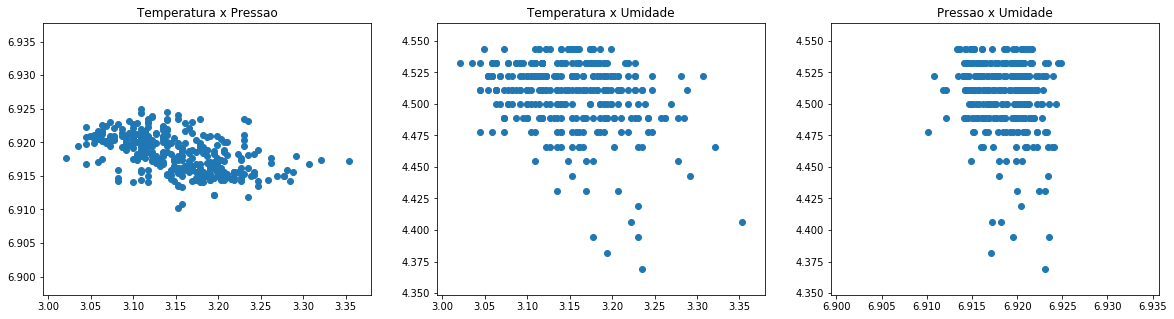

In [53]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(20, 5) 
axs[0].scatter(temperatura1_log,pressao1_log);
axs[0].set_title('Temperatura x Pressao');
axs[1].scatter(temperatura1_log,umidade1_log);
axs[1].set_title('Temperatura x Umidade');
axs[2].scatter(pressao1_log,umidade1_log);
axs[2].set_title('Pressao x Umidade');

##### Análise sem log

In [54]:
dados_com_chuva = dados5[dados5['precipitacao']>0]
dados_com_chuva.head()

,time,temp_inst,pressao,umid_inst,precipitacao
31,2018-11-07 02:00:00,23.8,1008.6,90,0.2
34,2018-11-07 10:00:00,27.4,1008.2,69,0.2
46,2018-11-07 01:00:00,23.6,1008.7,88,3
51,2018-11-08 02:00:00,22.9,1008.8,89,4.6
60,2018-11-08 01:00:00,24.1,1009.1,85,0.2


In [55]:
tempo1 = dados_com_chuva['time']
temperatura1 = dados_com_chuva['temp_inst']
pressao1 = dados_com_chuva['pressao']
umidade1 = dados_com_chuva['umid_inst']
precipitacao1 = dados_com_chuva['precipitacao']

temperatura1 = temperatura1.astype(float)
umidade1 = umidade1.astype(float)
pressao1 = pressao1.astype(float)
precipitacao1 = precipitacao1.astype(float)

temperatura1_log = temperatura1_log.astype(float)
umidade1_log = umidade1_log.astype(float)
pressao1_log = pressao1_log.astype(float)
precipitacao1_log = precipitacao1_log.astype(float)

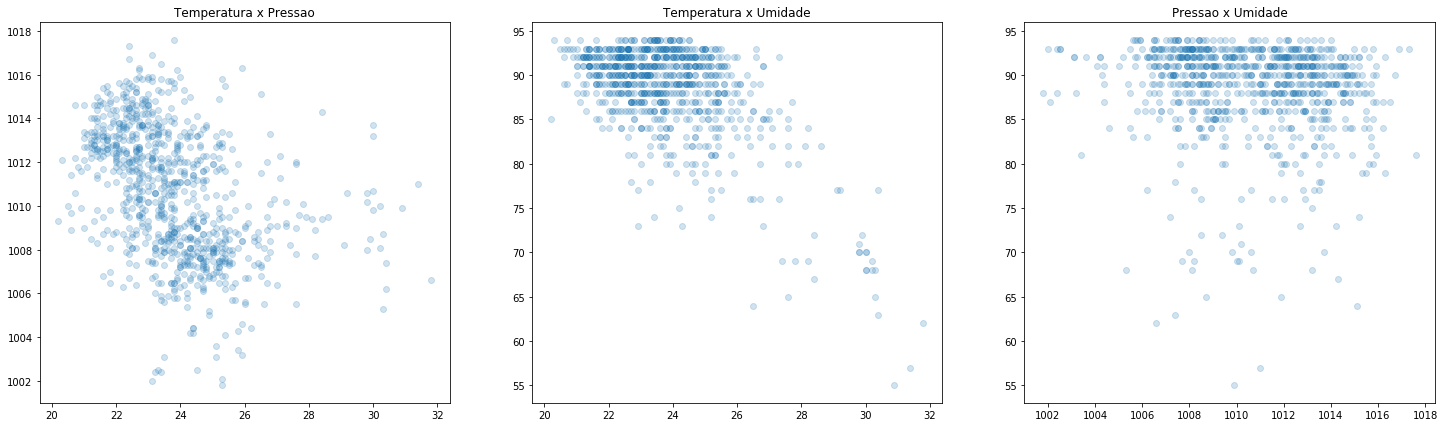

In [56]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(25, 7) 
axs[0].scatter(temperatura1,pressao1, alpha=0.2);
axs[0].set_title('Temperatura x Pressao');
axs[1].scatter(temperatura1,umidade1, alpha=0.2);
axs[1].set_title('Temperatura x Umidade');
axs[2].scatter(pressao1,umidade1, alpha=0.2);
axs[2].set_title('Pressao x Umidade');

#### Correlação entre as variáveis independentes

In [57]:
print('Correlação entre temperatura e pressão:', temperatura1.corr(pressao1))
print('Correlação entre temperatura e umidade:', temperatura1.corr(umidade1))
print('Correlação entre pressão e umidade:',pressao1.corr(umidade1))

Correlação entre temperatura e pressão: -0.4076880756078036
Correlação entre temperatura e umidade: -0.5950262535123811
Correlação entre pressão e umidade: -0.10983952939618111


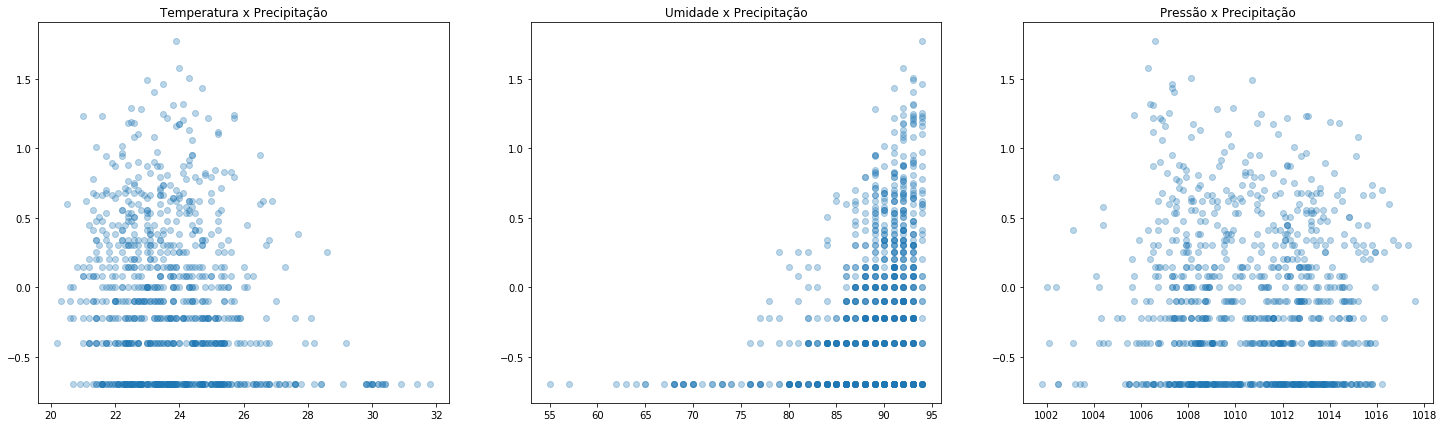

In [58]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(25, 7) 
axs[0].scatter(temperatura1,np.log10(precipitacao1), alpha=0.3);
axs[0].set_title('Temperatura x Precipitação');
axs[1].scatter(umidade1,np.log10(precipitacao1), alpha=0.3);
axs[1].set_title('Umidade x Precipitação');
axs[2].scatter(pressao1,np.log10(precipitacao1), alpha=0.3);
axs[2].set_title('Pressão x Precipitação');

#### Correlação entre as variáveis independentes e a variável dependente

In [59]:
print('Correlação entre temperatura e pressão:', np.log10(precipitacao1).corr(pressao1))
print('Correlação entre temperatura e umidade:', np.log10(precipitacao1).corr(umidade1))
print('Correlação entre pressão e umidade:',np.log10(precipitacao1).corr(temperatura1))

Correlação entre temperatura e pressão: -0.03963987120695977
Correlação entre temperatura e umidade: 0.4059043809724465
Correlação entre pressão e umidade: -0.19685016544813272


In [60]:
model = sm.OLS(np.log10(precipitacao1),sm.add_constant(umidade1))
results = model.fit()
results.summary()

/Users/joaopedrochacon/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           precipitacao   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     170.2
Date:                Tue, 12 Nov 2019   Prob (F-statistic):           1.22e-35
Time:                        14:22:15   Log-Likelihood:                -633.16
No. Observations:                 865   AIC:                             1270.
Df Residuals:                     863   BIC:                             1280.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.8165      0.287    -13.306      0.000      -4.379      -3.254
umid_inst      0.0422      0.003     13.047      0.000       0.036       0.049
==============================================================================
Omnibus:                       29.729   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.529
Skew:                           0.417   Prob(JB):                     3.87e-07
Kurtosis:                       2.647   Cond. No.                     1.49e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [61]:
model = sm.OLS(precipitacao1,sm.add_constant(umidade1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           precipitacao   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     52.74
Date:                Tue, 12 Nov 2019   Prob (F-statistic):           8.49e-13
Time:                        14:22:15   Log-Likelihood:                -2471.4
No. Observations:                 865   AIC:                             4947.
Df Residuals:                     863   BIC:                             4956.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -15.3015      2.402     -6.371      0.000     -20.016     -10.587
umid_inst      0.1967      0.027      7.262      0.000       0.144       0.250
==============================================================================
Omnibus:                     1013.997   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            99475.571
Skew:                           5.785   Prob(JB):                         0.00
Kurtosis:                      54.246   Cond. No.                     1.49e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [62]:
model = sm.OLS(precipitacao1,sm.add_constant(temperatura1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           precipitacao   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.440
Date:                Tue, 12 Nov 2019   Prob (F-statistic):             0.0640
Time:                        14:22:15   Log-Likelihood:                -2495.4
No. Observations:                 865   AIC:                             4995.
Df Residuals:                     863   BIC:                             5004.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7746      1.981      2.915      0.004       1.887       9.663
temp_inst     -0.1542      0.083     -1.855      0.064      -0.317       0.009
==============================================================================
Omnibus:                     1016.266   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            96316.032
Skew:                           5.826   Prob(JB):                         0.00
Kurtosis:                      53.364   Cond. No.                         321.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

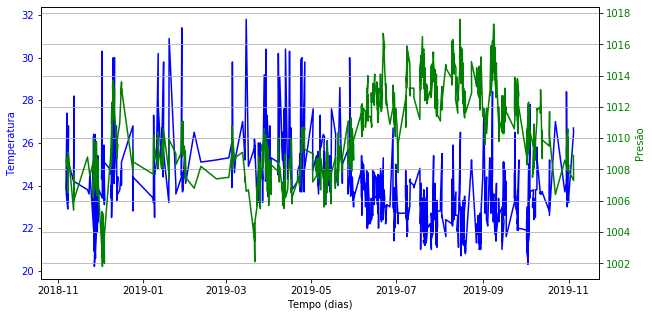

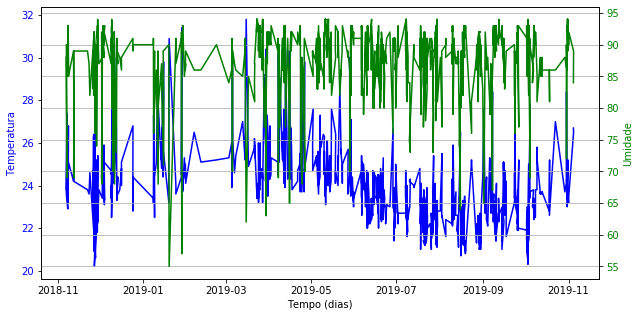

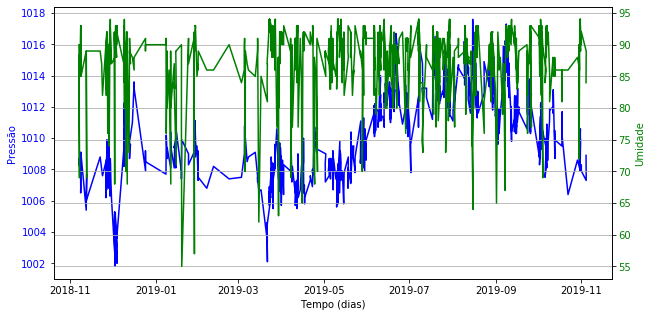

In [63]:
Grafico2Eixos(tempo1, 'Tempo (dias)', temperatura1,'Temperatura', pressao1, 'Presão')
Grafico2Eixos(tempo1, 'Tempo (dias)', temperatura1,'Temperatura', umidade1, 'Umidade')
Grafico2Eixos(tempo1, 'Tempo (dias)', pressao1,'Pressão', umidade1, 'Umidade')

___
## Analisando os dias que não tiveram chuvas

##### Análise com log

In [64]:
dados_log_sem_chuva = dados_log[dados_log['precipitacao']==0]
dados_log_sem_chuva.head()

,temp_inst,pressao,umid_inst,precipitacao
time,,,,
2018-11-22 05:00:00,3.169686,6.916517,4.488636,0.0
2018-11-26 22:00:00,3.072693,6.916418,4.521789,0.0
2018-11-26 23:00:00,3.077312,6.916616,4.521789,0.0
2018-11-27 22:00:00,3.025291,6.916616,4.488636,0.0
2018-12-02 08:00:00,3.190476,6.911946,4.521789,0.0


In [65]:
temperatura2_log = dados_log_com_chuva['temp_inst']
pressao2_log = dados_log_com_chuva['pressao']
umidade2_log = dados_log_com_chuva['umid_inst']
precipitacao2_log = dados_log_com_chuva['precipitacao']

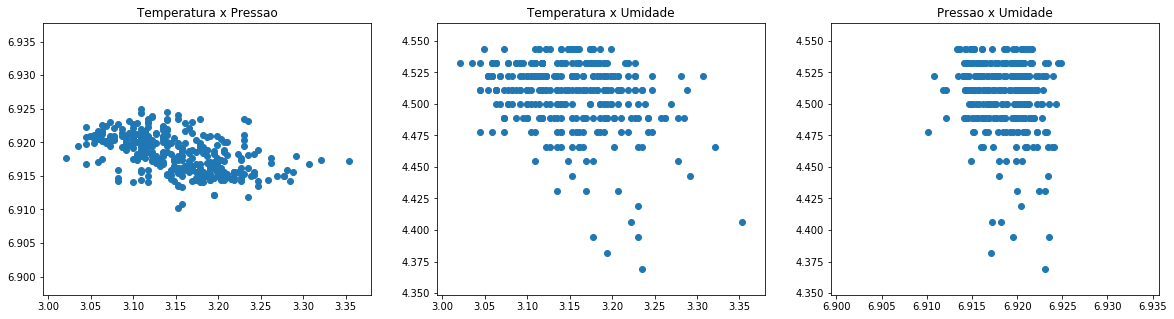

In [66]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(20, 5) 
axs[0].scatter(temperatura2_log,pressao2_log);
axs[0].set_title('Temperatura x Pressao');
axs[1].scatter(temperatura2_log,umidade2_log);
axs[1].set_title('Temperatura x Umidade');
axs[2].scatter(pressao2_log,umidade2_log);
axs[2].set_title('Pressao x Umidade');

##### Análise sem log

In [67]:
dados_sem_chuva = dados5[dados5['precipitacao']==0]
dados_sem_chuva.head()

,time,temp_inst,pressao,umid_inst,precipitacao
0,2018-11-06 08:00:00,24.6,1006.7,78,0
1,2018-11-06 16:00:00,29.9,1006.9,56,0
2,2018-11-06 04:00:00,24.7,1006.7,77,0
3,2018-11-06 11:00:00,27.3,1008.9,66,0
4,2018-11-06 02:00:00,25.1,1007.6,78,0


In [68]:
tempo2 = dados_sem_chuva['time']
temperatura2 = dados_sem_chuva['temp_inst']
pressao2 = dados_sem_chuva['pressao']
umidade2 = dados_sem_chuva['umid_inst']
precipitacao2 = dados_sem_chuva['precipitacao']

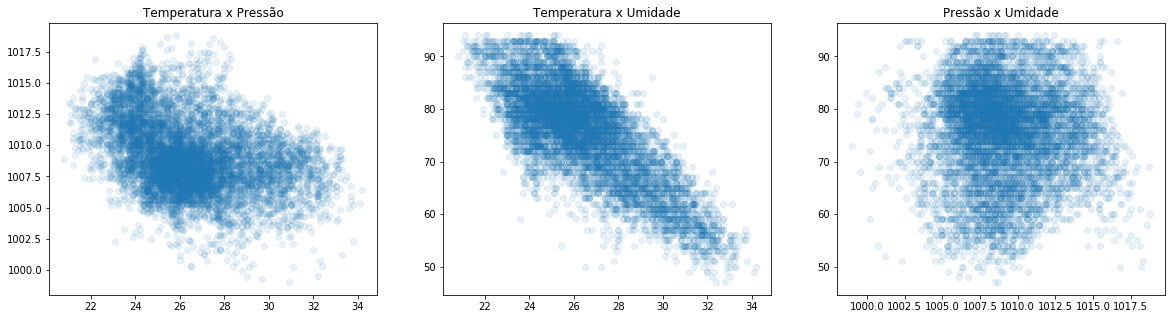

In [69]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(20, 5) 
axs[0].scatter(temperatura2,pressao2, alpha=0.1);
axs[0].set_title('Temperatura x Pressão');
axs[1].scatter(temperatura2,umidade2, alpha=0.1);
axs[1].set_title('Temperatura x Umidade');
axs[2].scatter(pressao2,umidade2, alpha=0.1);
axs[2].set_title('Pressão x Umidade');

***Valores de correlação entre as variáveis***

In [70]:
temperatura2 = temperatura2.astype(float)
umidade2 = umidade2.astype(float)
pressao2 = pressao2.astype(float)
print('Correlação entre temperatura e pressão:', temperatura2.corr(pressao2))
print('Correlação entre temperatura e umidade:', temperatura2.corr(umidade2))
print('Correlação entre pressão e umidade:',pressao2.corr(umidade2))

Correlação entre temperatura e pressão: -0.37013423515633465
Correlação entre temperatura e umidade: -0.7607690347330318
Correlação entre pressão e umidade: -0.0234013734262953


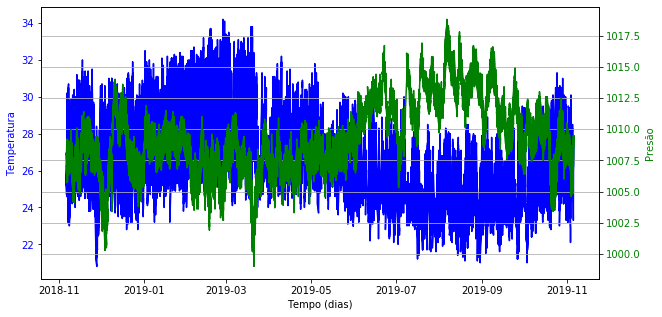

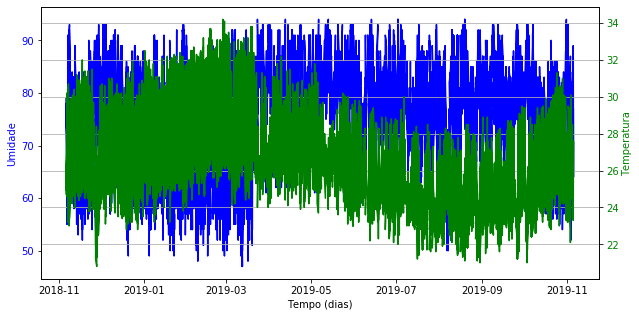

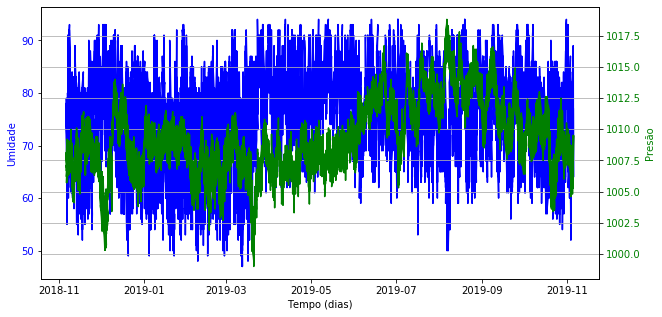

In [71]:
Grafico2Eixos(tempo2, 'Tempo (dias)', temperatura2,'Temperatura', pressao2, 'Presão')
Grafico2Eixos(tempo2, 'Tempo (dias)', umidade2, 'Umidade', temperatura2,'Temperatura')
Grafico2Eixos(tempo2, 'Tempo (dias)',umidade2, 'Umidade',pressao2, 'Presão')

In [91]:
### Função utilitária para fazer a regressão com constante adicionada
def regress(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

In [98]:
Y = dados_log_com_chuva['precipitacao'].astype(float)

In [100]:
X3 = dados_log_com_chuva[['temp_inst', 'pressao', 'umid_inst']].astype(float)

results3 = regress(X3, Y)
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           precipitacao   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     12.87
Date:                Tue, 12 Nov 2019   Prob (F-statistic):           5.75e-08
Time:                        14:32:15   Log-Likelihood:                -382.43
No. Observations:                 331   AIC:                             772.9
Df Residuals:                     327   BIC:                             788.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -28.8033    136.232     -0.211      0.833    -296.805     239.198
temp_inst      2.0694      0.955      2.168      0.031       0.191       3.947
pressao       -2.8081     18.923     -0.148      0.882     -40.034      34.418
umid_inst      9.5125      1.736      5.481      0.000       6.098      12.927
==============================================================================
Omnibus:                       18.729   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.928
Skew:                           0.614   Prob(JB):                     2.85e-05
Kurtosis:                       2.911   Cond. No.                     2.88e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.88e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""